In [2]:
#setting up colab for downloading kaggle datasets directly
from google.colab import files
files.upload()
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download -d puneet6060/intel-image-classification #download the dataset

 97% 337M/346M [00:02<00:00, 129MB/s]
100% 346M/346M [00:02<00:00, 137MB/s]


In [0]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image
import numpy as np
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

In [5]:
#extract the data
for file in os.listdir():
    if '.zip' in file:
      zip_ref = zipfile.ZipFile(file, 'r')
      zip_ref.extractall()
      zip_ref.close()
      print('done')

done


In [0]:
train_dir = '/content/seg_train/seg_train'
val_dir = '/content/seg_test/seg_test'
#os.listdir(train_dir)

In [75]:
print('Training data distribution\n')
for class_folder in os.listdir(train_dir):
  print(class_folder, '->', str(len(os.listdir(train_dir+'/'+class_folder))), ' images')
print('\nValidation Data distribution\n')
for class_folder in os.listdir(val_dir):
  print(class_folder, '->', str(len(os.listdir(val_dir+'/'+class_folder))), ' images')

Training data distribution

mountain -> 2512  images
street -> 2382  images
glacier -> 2404  images
buildings -> 2191  images
sea -> 2274  images
forest -> 2271  images

Validation Data distribution

mountain -> 525  images
street -> 501  images
glacier -> 553  images
buildings -> 437  images
sea -> 510  images
forest -> 474  images


In [0]:
#initialize data generators and used image augmentation for reducing overfitting ->image rotation, shear, zoom , horizontal flipping, height and width reduction
train_gen = ImageDataGenerator(rescale=1/255.0, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_gen = ImageDataGenerator(rescale=1/255.0, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

In [44]:
#provide the directories for the generators
train_data = train_gen.flow_from_directory(directory=train_dir, target_size=(150, 150), batch_size=64, class_mode='categorical')
val_data = val_gen.flow_from_directory(directory=val_dir, target_size=(150, 150), batch_size=64, class_mode='categorical', shuffle=False)

Found 3000 images belonging to 6 classes.


In [0]:
early_stop = EarlyStopping(monitor='categorical_accuracy', min_delta=0.01, patience=5, verbose=1) #initialize early stopping

In [0]:
num_classes = train_data.num_classes #find number of classes of data
#initialize the model
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(150, 150, 3), padding='same'),
                                    tf.keras.layers.MaxPooling2D(2, 2),
                                    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2, 2),
                                    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
                                    tf.keras.layers.MaxPooling2D(2, 2),
                                    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
                                    tf.keras.layers.MaxPooling2D(2, 2),
                                    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
                                    tf.keras.layers.MaxPooling2D(2, 2),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(1024, activation='relu'),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy', tf.keras.metrics.Precision()]) #compile the model with loss function, optimizer function and metrics

In [78]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 75, 75, 64)        51264     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 18, 18, 256)      

In [88]:
history = model.fit(train_data, steps_per_epoch=220, epochs=50, validation_data=val_data, validation_steps=47, callbacks=[early_stop]) #model.fit supports generators

Epoch 1/50
220/220 [==============================] - 119s 540ms/step - loss: 0.8104 - categorical_accuracy: 0.7009 - precision_2: 0.7732 - val_loss: 0.7408 - val_categorical_accuracy: 0.7233 - val_precision_2: 0.7830
Epoch 2/50
220/220 [==============================] - 117s 532ms/step - loss: 0.7321 - categorical_accuracy: 0.7317 - precision_2: 0.7927 - val_loss: 0.7176 - val_categorical_accuracy: 0.7293 - val_precision_2: 0.7992
Epoch 3/50
220/220 [==============================] - 120s 547ms/step - loss: 0.6909 - categorical_accuracy: 0.7473 - precision_2: 0.8023 - val_loss: 0.6666 - val_categorical_accuracy: 0.7600 - val_precision_2: 0.8127
Epoch 4/50
220/220 [==============================] - 118s 534ms/step - loss: 0.6557 - categorical_accuracy: 0.7626 - precision_2: 0.8138 - val_loss: 0.6346 - val_categorical_accuracy: 0.7740 - val_precision_2: 0.8317
Epoch 5/50
220/220 [==============================] - 119s 542ms/step - loss: 0.6458 - categorical_accuracy: 0.7643 - precision_

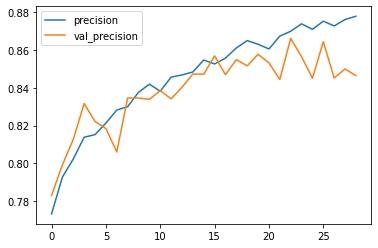

In [90]:
plt.plot(history.history['precision_2'], label='precision')
plt.plot(history.history['val_precision_2'], label='val_precision')
plt.legend()
plt.show()

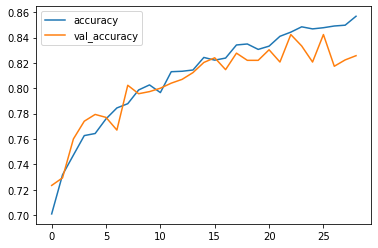

In [89]:
plt.plot(history.history['categorical_accuracy'], label='accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [0]:
pred_dir = '/content/seg_pred/seg_pred'

In [92]:
val_data.reset()
predictions = model.predict(val_data)
predicted_classes = np.argmax(predictions, axis = 1)

true_classes = val_data.classes
class_labels = list(val_data.class_indices.keys())

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

   buildings       0.86      0.69      0.76       437
      forest       0.97      0.93      0.95       474
     glacier       0.74      0.83      0.78       553
    mountain       0.77      0.77      0.77       525
         sea       0.81      0.81      0.81       510
      street       0.81      0.88      0.84       501

    accuracy                           0.82      3000
   macro avg       0.83      0.82      0.82      3000
weighted avg       0.82      0.82      0.82      3000



In [0]:
def image_display(img_path):
  img=mpimg.imread(img_path)
  imgplot = plt.imshow(img)
  plt.show()

In [0]:
def predict(img_path):
  img = image.load_img(img_path, target_size=(150, 150))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  pred = model.predict(img)
  return pred

In [0]:
def find(classes, index):
  for key, value in classes.items():
    if value == index:
      print(key)

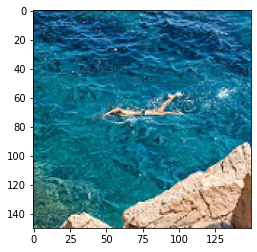

sea


In [93]:
preds = []
val_data.reset()
classes = val_data.class_indices
path = pred_dir+'/4588.jpg'
image_display(path)
pred = np.argmax(predict(path), axis=1)
find(classes , pred)